# Fine-tuning YOLO11 on an RPS dataset
This is supposed to be a very basic practice project for learning how to work with the ultralytics library and yolo models.

by Gholamreza Dar 2024

In [1]:
!pip install -qU ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00


## Huggingface Stuff

In [2]:
# Huggingface login and helper functions
HF_REPO_ID = "Gholamreza/yolo11_rock_paper_scissors_detection"

from google.colab import userdata
import huggingface_hub
from huggingface_hub import login, hf_hub_download, HfApi

def save_to_hub(file_name, file_in_repo_name=None, repo_id=HF_REPO_ID):
    if file_in_repo_name == None:
        file_in_repo_name = file_name

    api = HfApi()
    api.upload_file(
        path_or_fileobj=file_name,
        path_in_repo=file_in_repo_name,
        repo_id=repo_id,
        repo_type="model",
    )
    print(f">> Uploaded {file_name} to {repo_id}/{file_in_repo_name}")

def save_folder_to_hub(folder_name, repo_id=HF_REPO_ID):
    api = HfApi()
    api.upload_folder(
        folder_path=folder_name,
        repo_id=repo_id,
        repo_type="model",
    )
    print(f">> Uploaded {folder_name} to {repo_id}/{folder_name}")

def load_from_hub(folder_in_repo, repo_id=HF_REPO_ID):
    return hf_hub_download(repo_id=repo_id, filename=folder_in_repo)

login(token=userdata.get('HF_TOKEN'))

## Download and prepare the data

Dataset: [rock-paper-scissors](https://universe.roboflow.com/roboflow-58fyf/rock-paper-scissors-sxsw) on roboflow universe

In [3]:
from roboflow import Roboflow
from google.colab import userdata

token = userdata.get('RF_TOKEN')
rf = Roboflow(api_key=token)
project = rf.workspace("roboflow-58fyf").project("rock-paper-scissors-sxsw")
version = project.version(14)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to rock-paper-scissors-14 in yolov11:: 100%|██████████| 14682/14682 [00:02<00:00, 6976.12it/s]


In [4]:
# what is the size of the dataset in MB
!du -sh {dataset.location}

257M	/content/rock-paper-scissors-14


In [5]:
print("name:", dataset.name)
print("version:", dataset.version)
print("model_format:", dataset.model_format)
print("location:", dataset.location) # we need this later

name: rock-paper-scissors
version: 14
model_format: yolov11
location: /content/rock-paper-scissors-14


In [6]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['Paper', 'Rock', 'Scissors']

roboflow:
  workspace: roboflow-58fyf
  project: rock-paper-scissors-sxsw
  version: 14
  license: Private
  url: https://universe.roboflow.com/roboflow-58fyf/rock-paper-scissors-sxsw/dataset/14

## Fine-tune the model

In [7]:
from ultralytics import YOLO
import os

# Load a pretrained YOLOv11 model
model = YOLO('yolo11n.pt')

# Fine-tune the model using your dataset
results = model.train(
    data=os.path.join(dataset.location, "data.yaml"),  # Path to your data.yaml file
    epochs=25,                 # Number of epochs for fine-tuning
    imgsz=640,                 # Image size for training
    # save_period=5,             # Save weights every epoch
    name='yolo11n_rps',
    fraction=1,
    val=True,
    plots=True,
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 15.1MB/s]


Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/rock-paper-scissors-14/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n_rps, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 3.41MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/rock-paper-scissors-14/train/labels... 6455 images, 2516 backgrounds, 0 corrupt: 100%|██████████| 6455/6455 [00:03<00:00, 2080.09it/s]


train: New cache created: /content/rock-paper-scissors-14/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/rock-paper-scissors-14/valid/labels... 576 images, 238 backgrounds, 0 corrupt: 100%|██████████| 576/576 [00:00<00:00, 814.68it/s]


val: New cache created: /content/rock-paper-scissors-14/valid/labels.cache
Plotting labels to runs/detect/yolo11n_rps/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11n_rps
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.58G      1.291      3.207      1.469          7        640: 100%|██████████| 404/404 [02:22<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.19it/s]

                   all        576        400      0.645      0.412        0.5       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.36G      1.409       2.28      1.508          7        640: 100%|██████████| 404/404 [02:14<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.27it/s]

                   all        576        400      0.386      0.377      0.308      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.37G      1.404      1.978        1.5          6        640: 100%|██████████| 404/404 [02:14<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]

                   all        576        400      0.557      0.502      0.527      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.37G      1.382      1.819      1.494          6        640: 100%|██████████| 404/404 [02:12<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]

                   all        576        400      0.703      0.585      0.678      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.37G      1.309       1.62      1.436         15        640: 100%|██████████| 404/404 [02:11<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.15it/s]

                   all        576        400      0.721      0.708      0.761      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.37G      1.239      1.488      1.386          7        640: 100%|██████████| 404/404 [02:15<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.15it/s]

                   all        576        400      0.786      0.716      0.813      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.37G      1.201      1.379      1.356          4        640: 100%|██████████| 404/404 [02:16<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.29it/s]

                   all        576        400      0.845      0.697      0.828       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.37G      1.168      1.287      1.335          9        640: 100%|██████████| 404/404 [02:15<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.32it/s]

                   all        576        400      0.824      0.783      0.847      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.37G      1.108      1.189       1.29          6        640: 100%|██████████| 404/404 [02:15<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.87it/s]

                   all        576        400       0.81      0.853      0.893      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.37G      1.095       1.16      1.288          9        640: 100%|██████████| 404/404 [02:13<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.93it/s]

                   all        576        400      0.872       0.81      0.864      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.37G      1.085      1.122       1.27          8        640: 100%|██████████| 404/404 [02:13<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.95it/s]

                   all        576        400      0.872      0.866      0.913      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      2.37G      1.058      1.056       1.25          8        640: 100%|██████████| 404/404 [02:16<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.23it/s]


                   all        576        400      0.872      0.854      0.922      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.37G      1.025      1.007      1.235         10        640: 100%|██████████| 404/404 [02:16<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.26it/s]

                   all        576        400       0.83      0.866       0.91      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.37G     0.9971     0.9663      1.218         12        640: 100%|██████████| 404/404 [02:15<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.38it/s]

                   all        576        400      0.927      0.873      0.927      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.37G     0.9712     0.9108      1.204          9        640: 100%|██████████| 404/404 [02:16<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.86it/s]

                   all        576        400      0.914      0.879      0.934      0.703


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.54G     0.8586     0.6387      1.149          7        640: 100%|██████████| 404/404 [02:13<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]

                   all        576        400      0.882      0.894      0.924      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.37G      0.835     0.6035      1.136          5        640: 100%|██████████| 404/404 [02:09<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.44it/s]

                   all        576        400      0.908      0.904      0.925      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.37G     0.8019     0.5569      1.115          4        640: 100%|██████████| 404/404 [02:13<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.48it/s]

                   all        576        400       0.92      0.899      0.937      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.37G     0.7658     0.5149      1.089          2        640: 100%|██████████| 404/404 [02:13<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.08it/s]

                   all        576        400       0.93      0.901      0.946       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.37G      0.746       0.49      1.075          4        640: 100%|██████████| 404/404 [02:13<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]

                   all        576        400      0.926       0.92      0.943      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.37G     0.7173     0.4693      1.057          6        640: 100%|██████████| 404/404 [02:12<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]

                   all        576        400      0.938      0.927      0.952      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.37G     0.7005     0.4374      1.045          6        640: 100%|██████████| 404/404 [02:13<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.16it/s]

                   all        576        400      0.956      0.905      0.948      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.37G     0.6709      0.415       1.03          2        640: 100%|██████████| 404/404 [02:09<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.37it/s]

                   all        576        400      0.947      0.924      0.957      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.37G     0.6474     0.3944      1.006          4        640: 100%|██████████| 404/404 [02:17<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.28it/s]

                   all        576        400      0.929      0.923      0.952      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.37G     0.6254     0.3776          1          3        640: 100%|██████████| 404/404 [02:16<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  4.11it/s]

                   all        576        400      0.946      0.909      0.953      0.769



25 epochs completed in 0.979 hours.
Optimizer stripped from runs/detect/yolo11n_rps/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n_rps/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n_rps/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:07<00:00,  2.55it/s]


                   all        576        400      0.929      0.924      0.952      0.769
                 Paper        132        139      0.935      0.921      0.961      0.784
                  Rock        121        141      0.936      0.934      0.941      0.744
              Scissors        116        120      0.917      0.919      0.955       0.78
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/yolo11n_rps


In [8]:
save_folder_to_hub("runs")

events.out.tfevents.1733959788.8eba00ac2eb2.807.0:   0%|          | 0.00/287k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

best.pt:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

last.pt:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

>> Uploaded runs to Gholamreza/yolo11_rock_paper_scissors_detection/runs


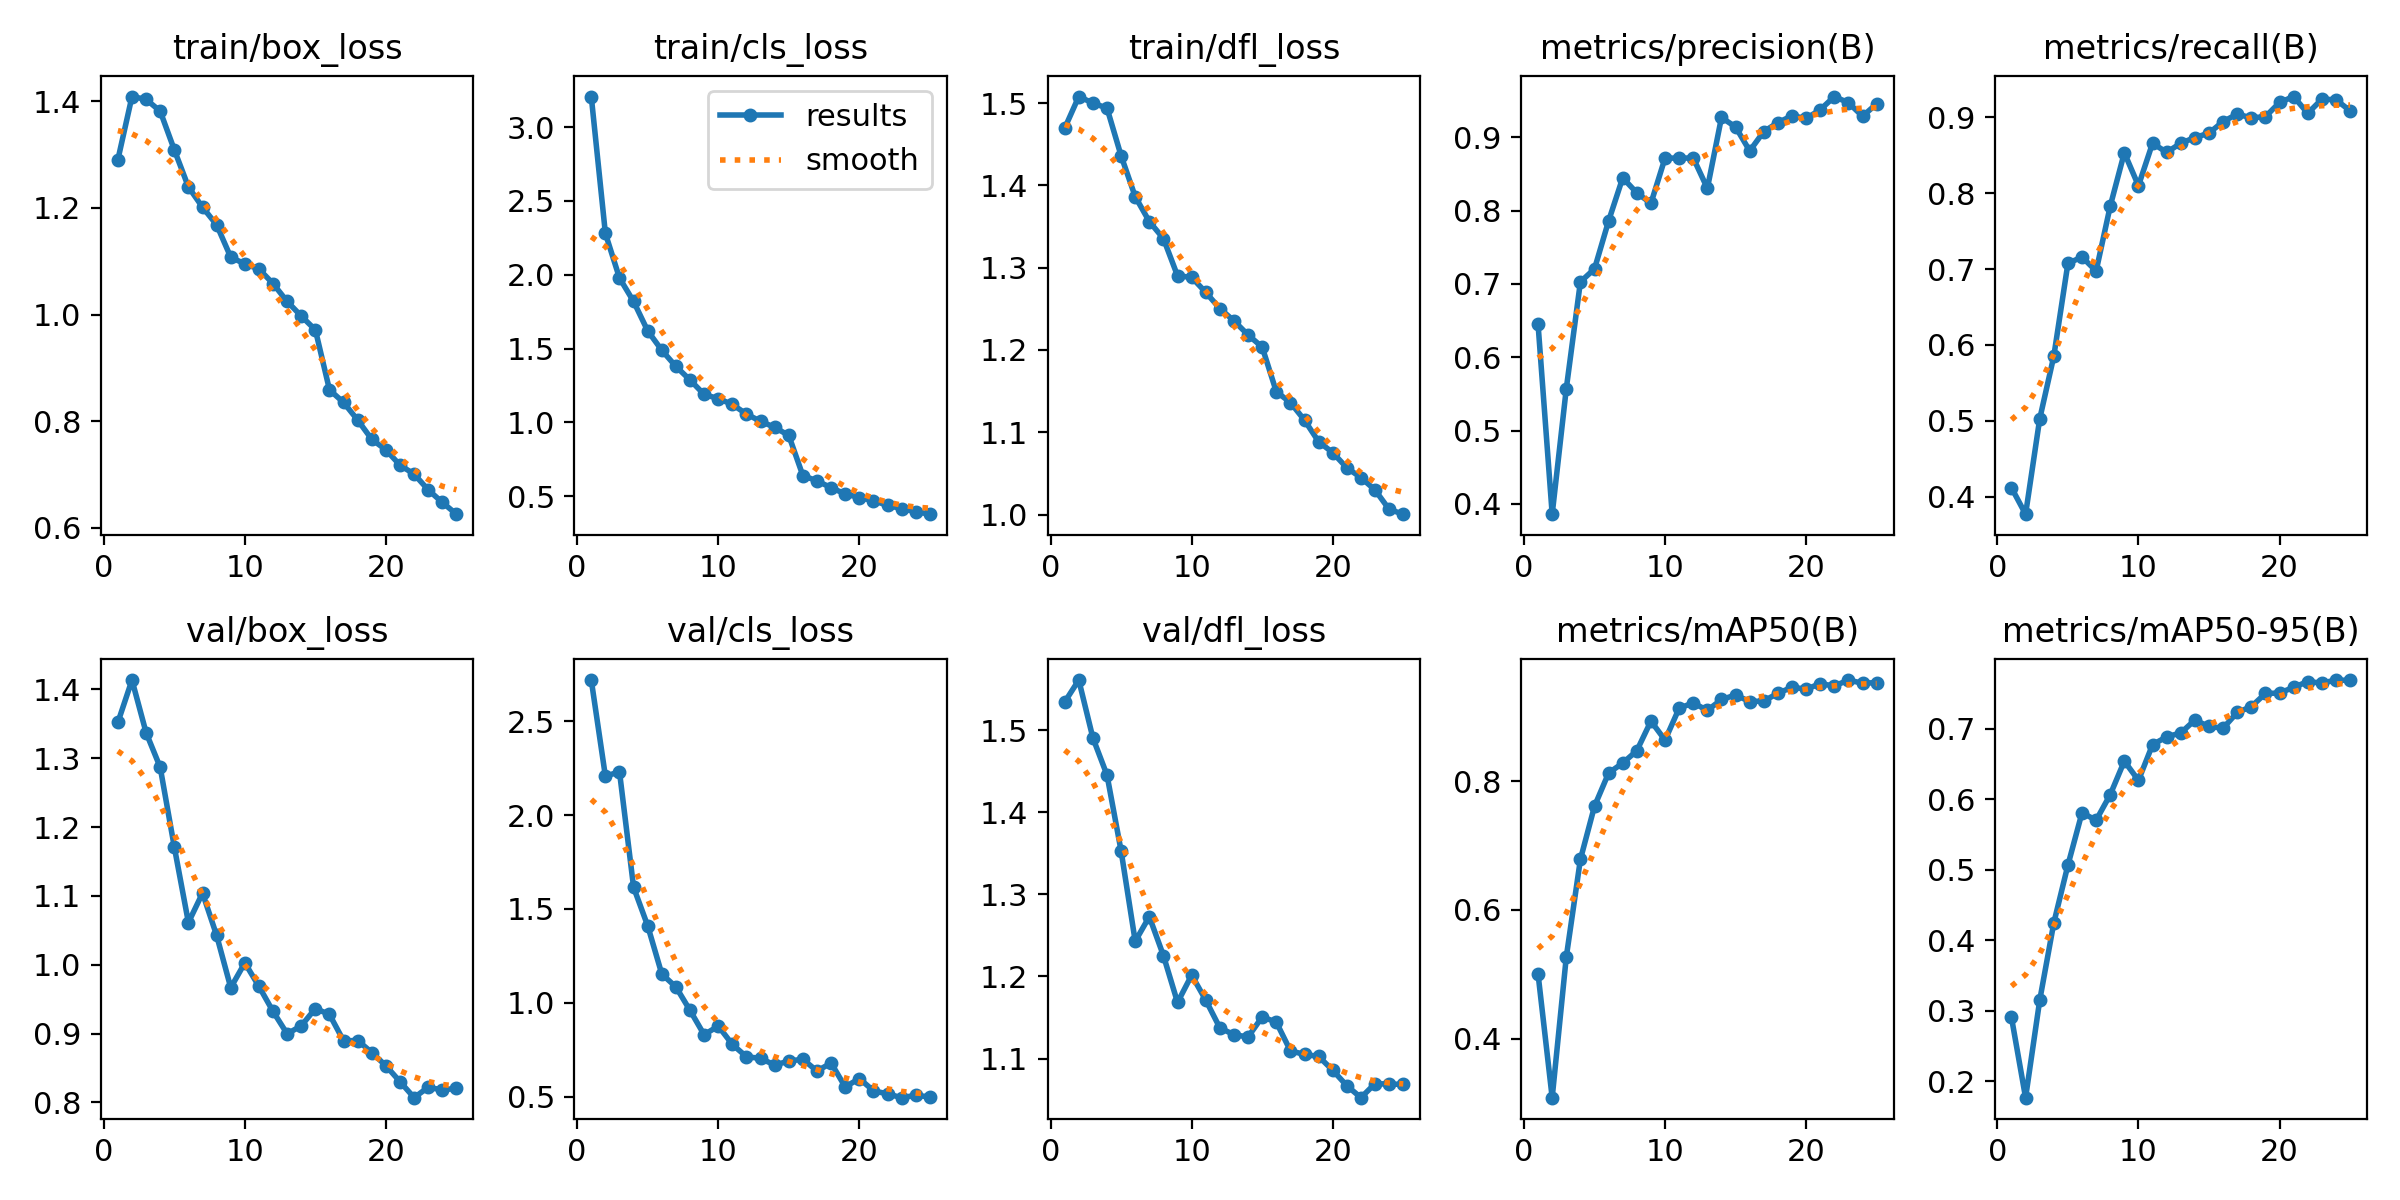

In [9]:
from IPython.display import Image
Image(filename='runs/detect/yolo11n_rps/results.png', width=1200)

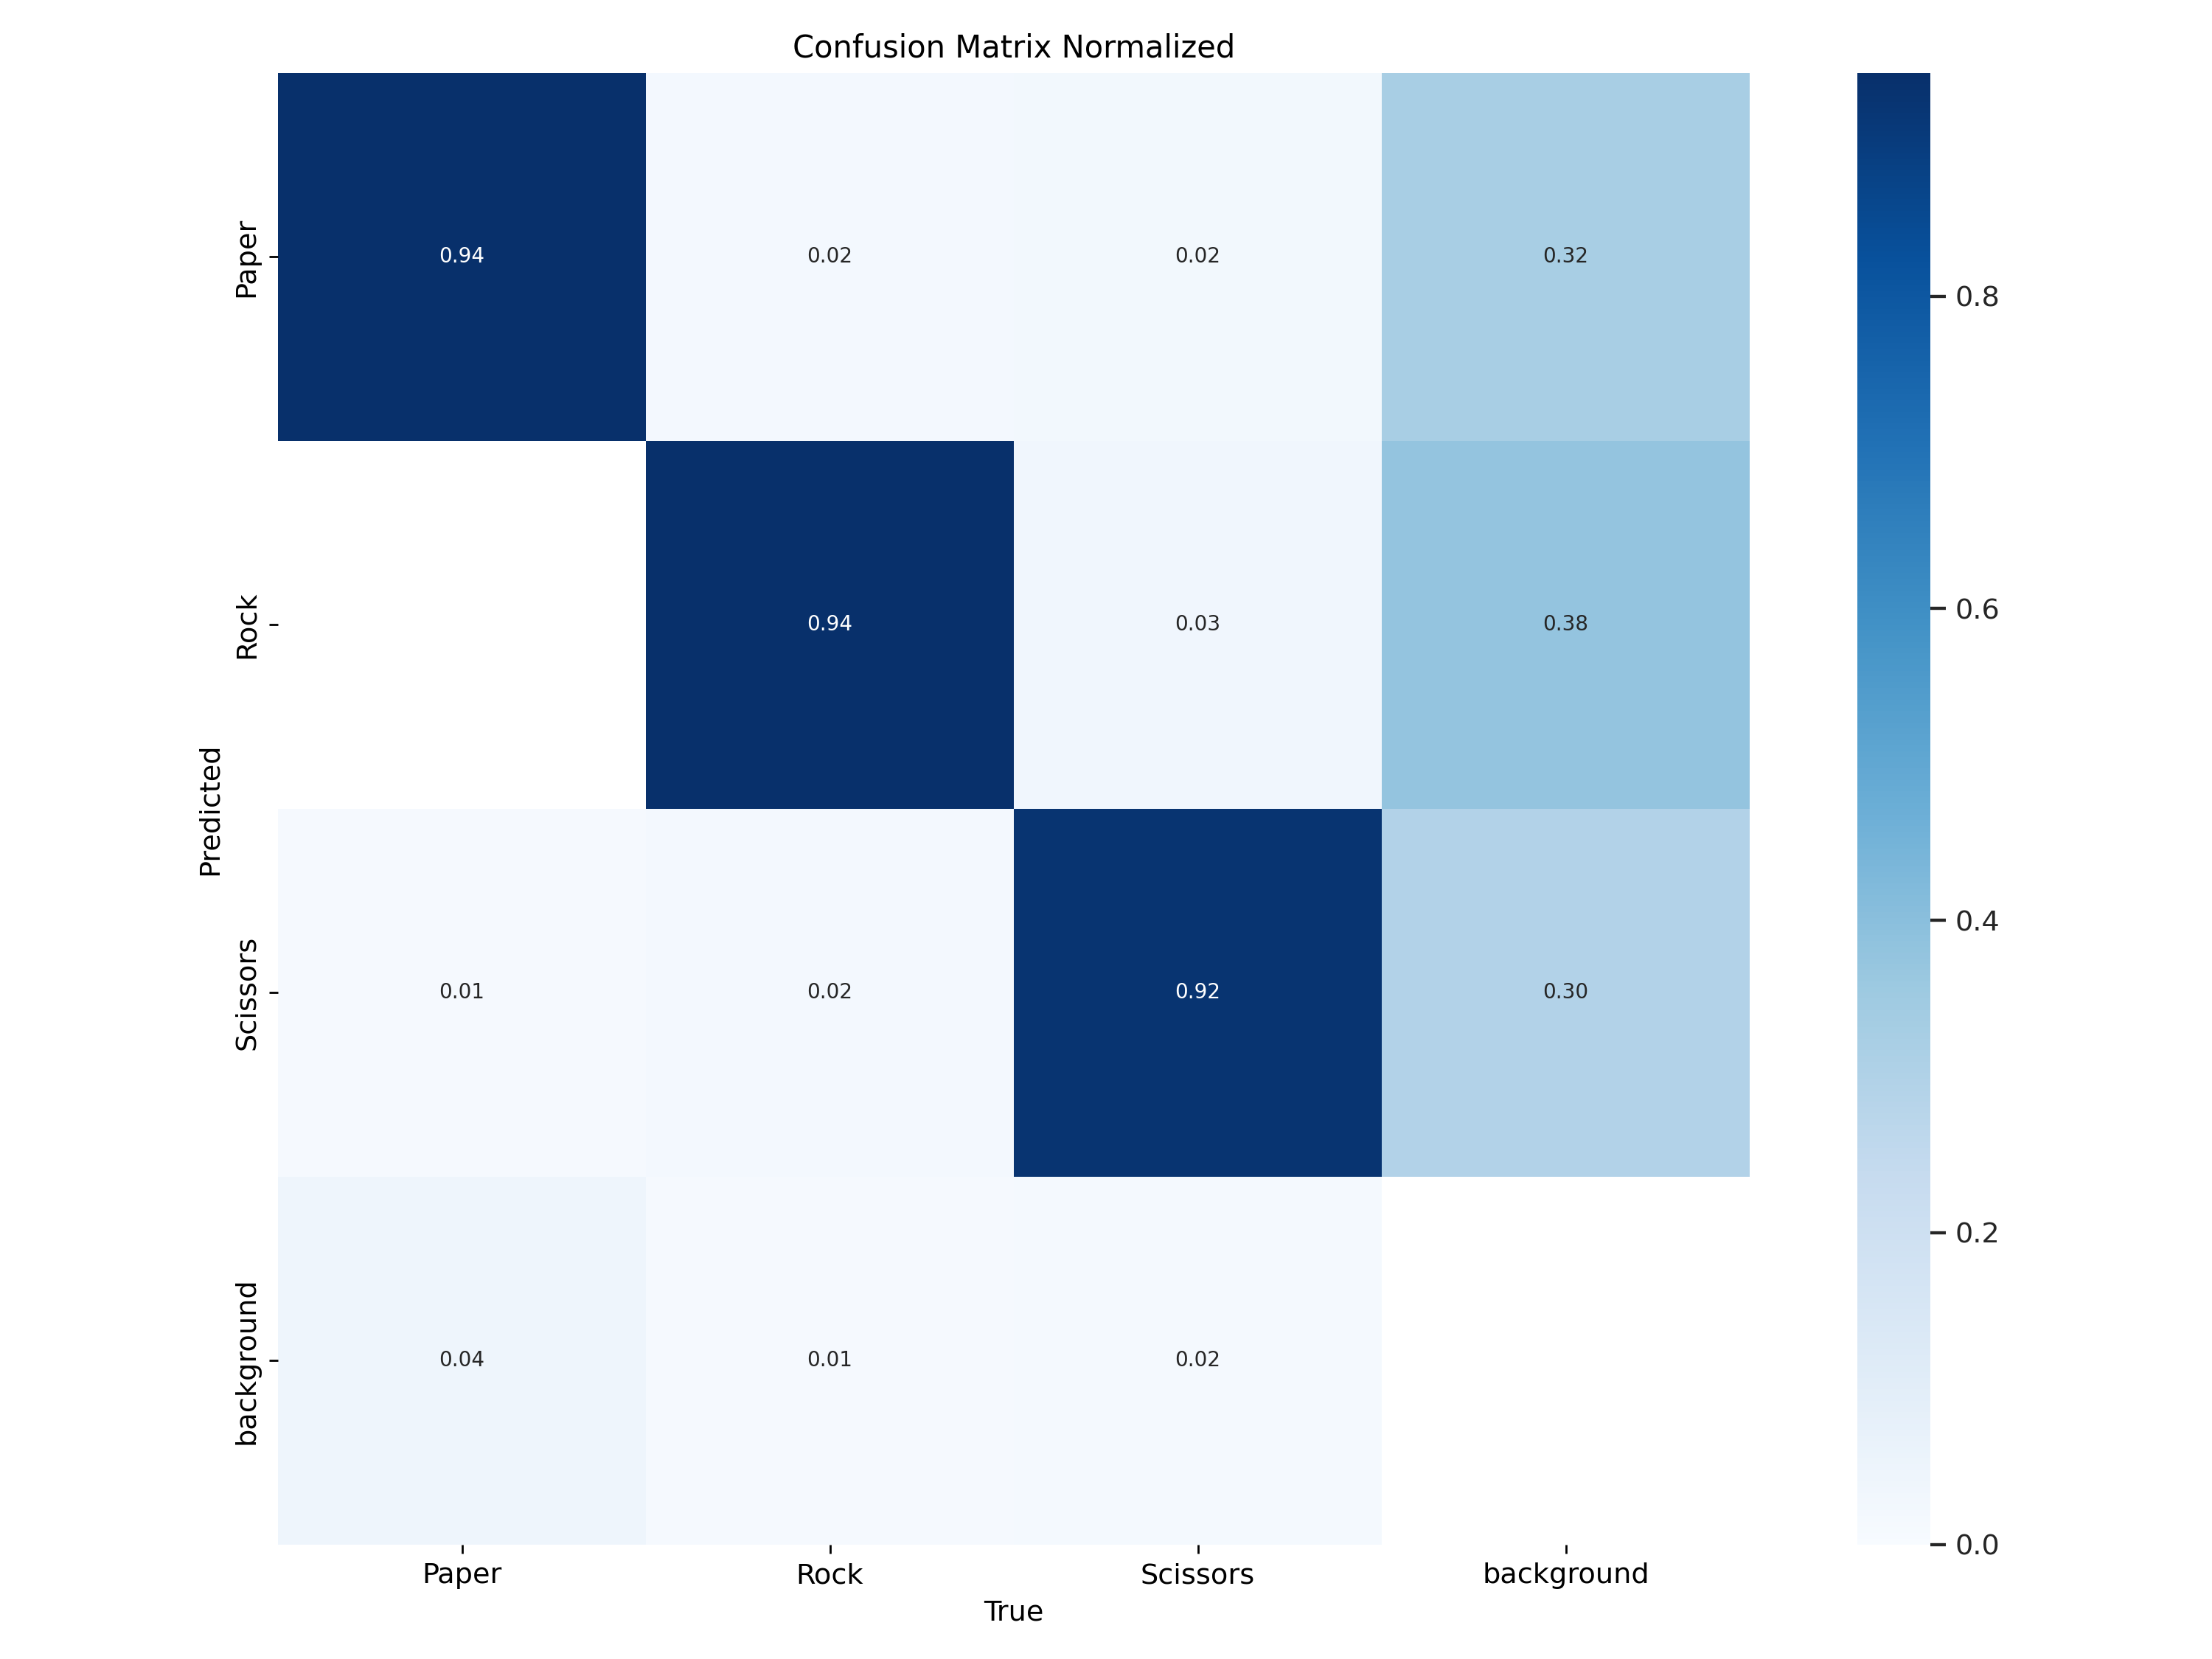

In [10]:
Image(filename='runs/detect/yolo11n_rps/confusion_matrix_normalized.png', width=1000)

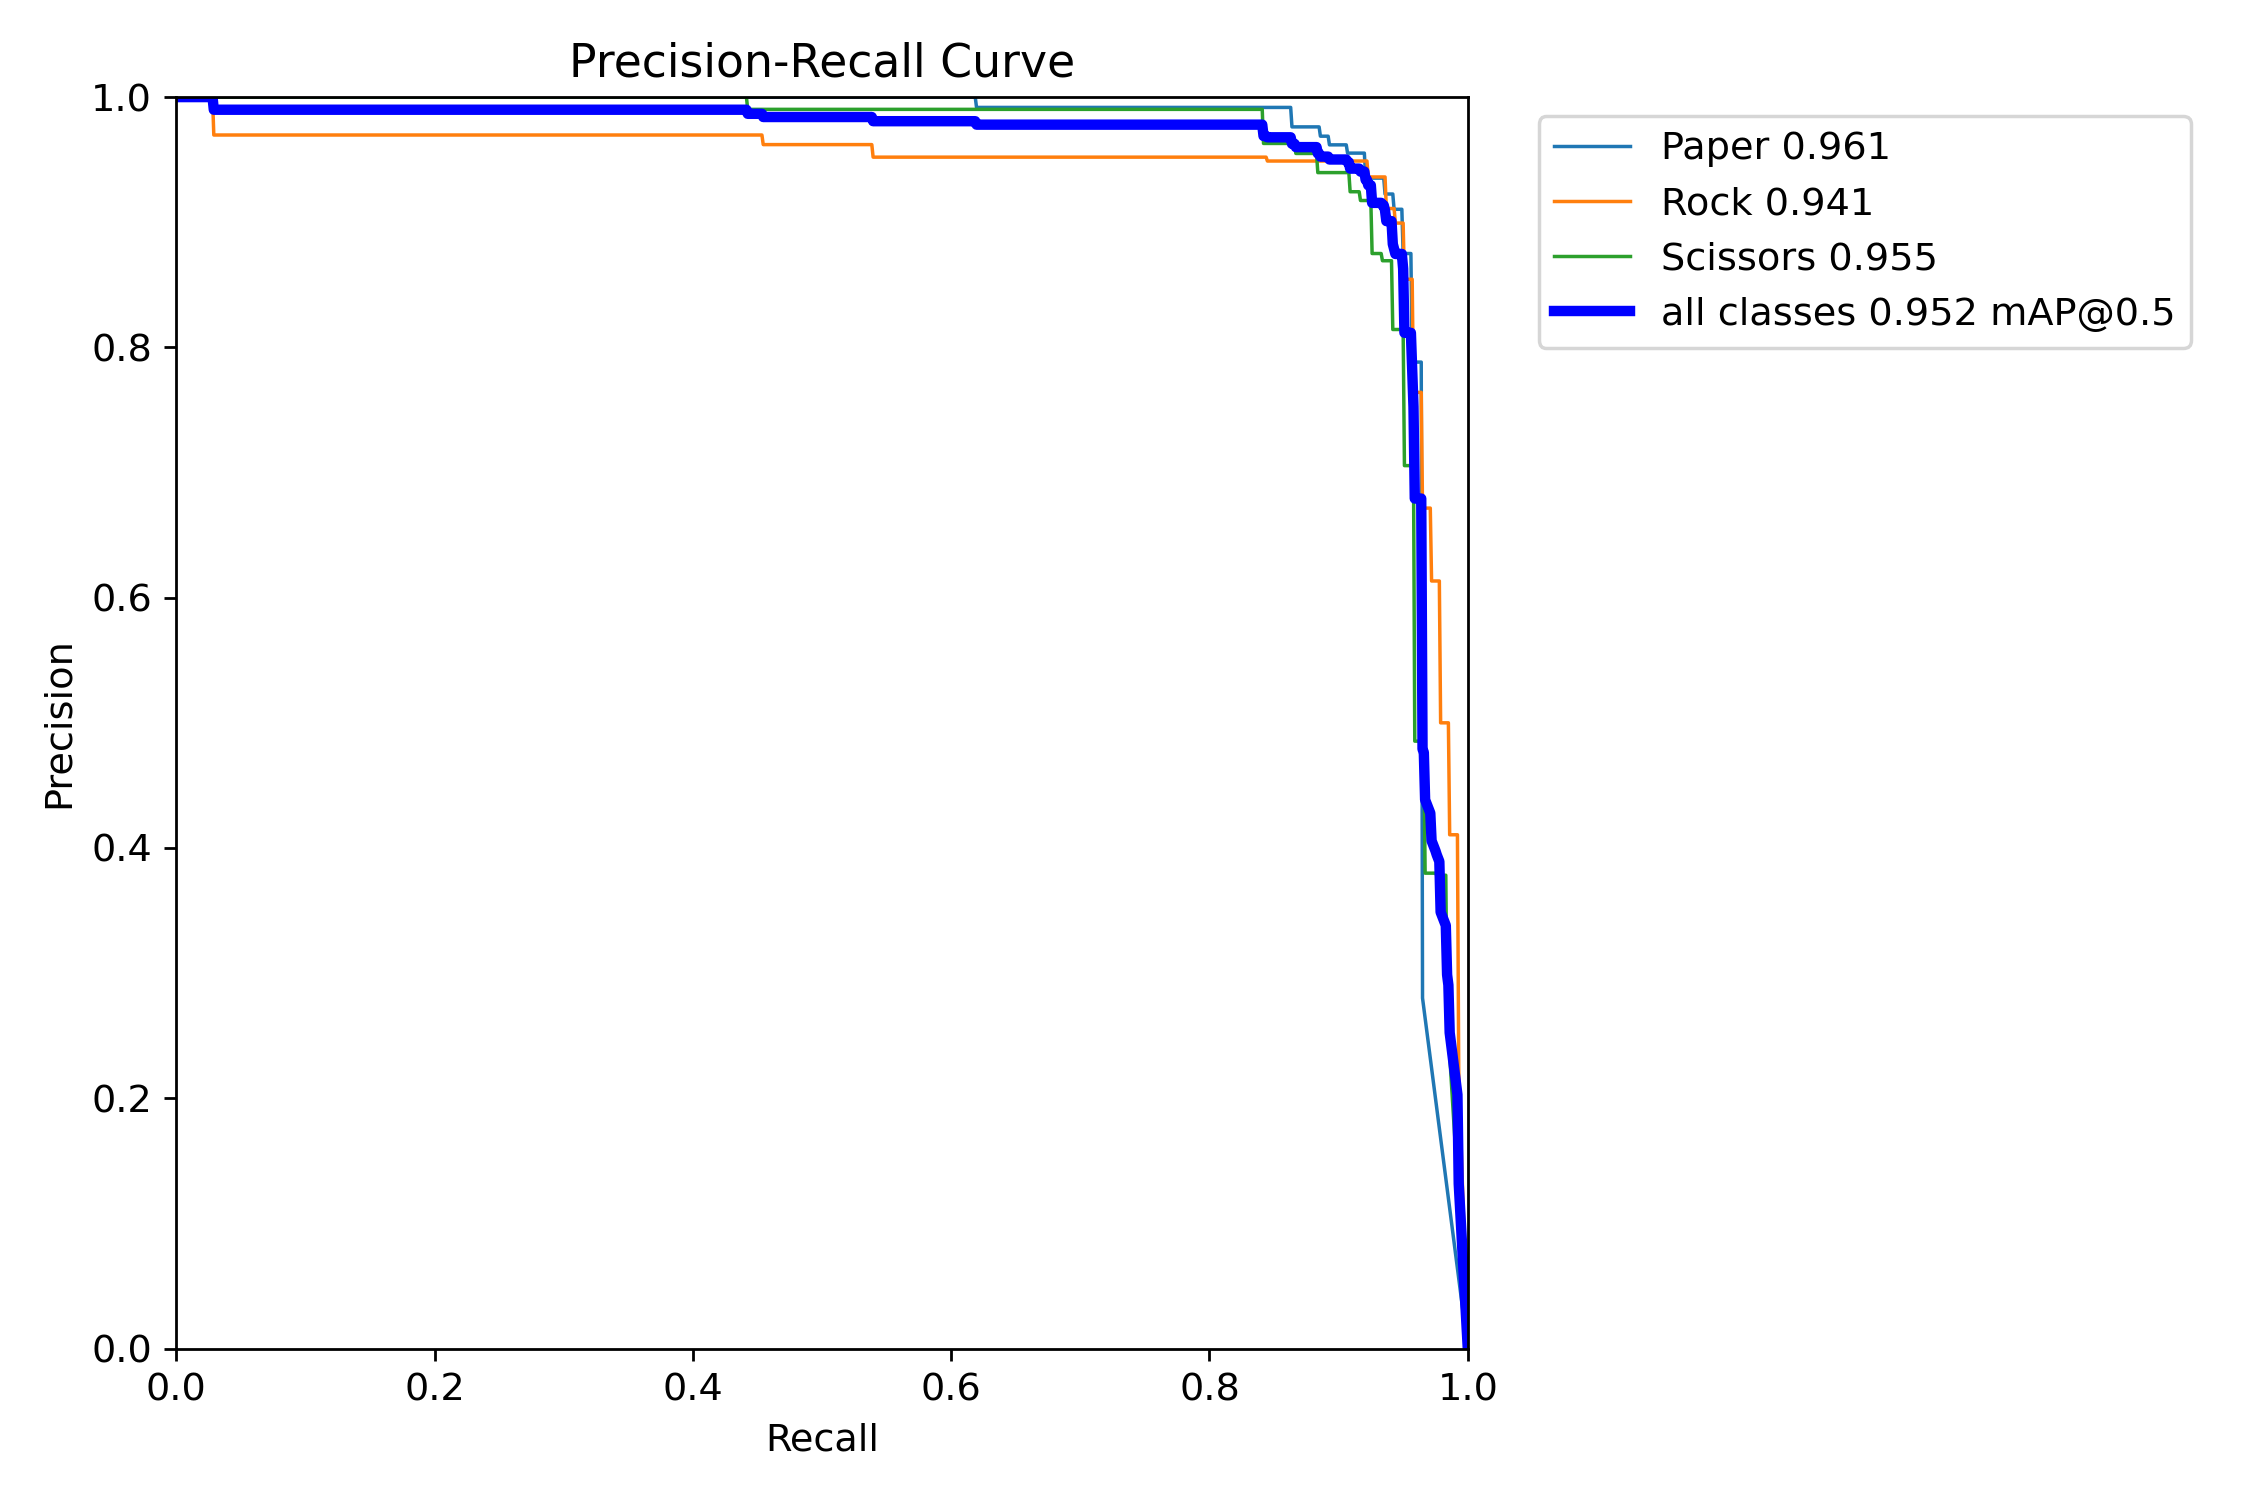

In [11]:
Image(filename='runs/detect/yolo11n_rps/PR_curve.png', width=600)

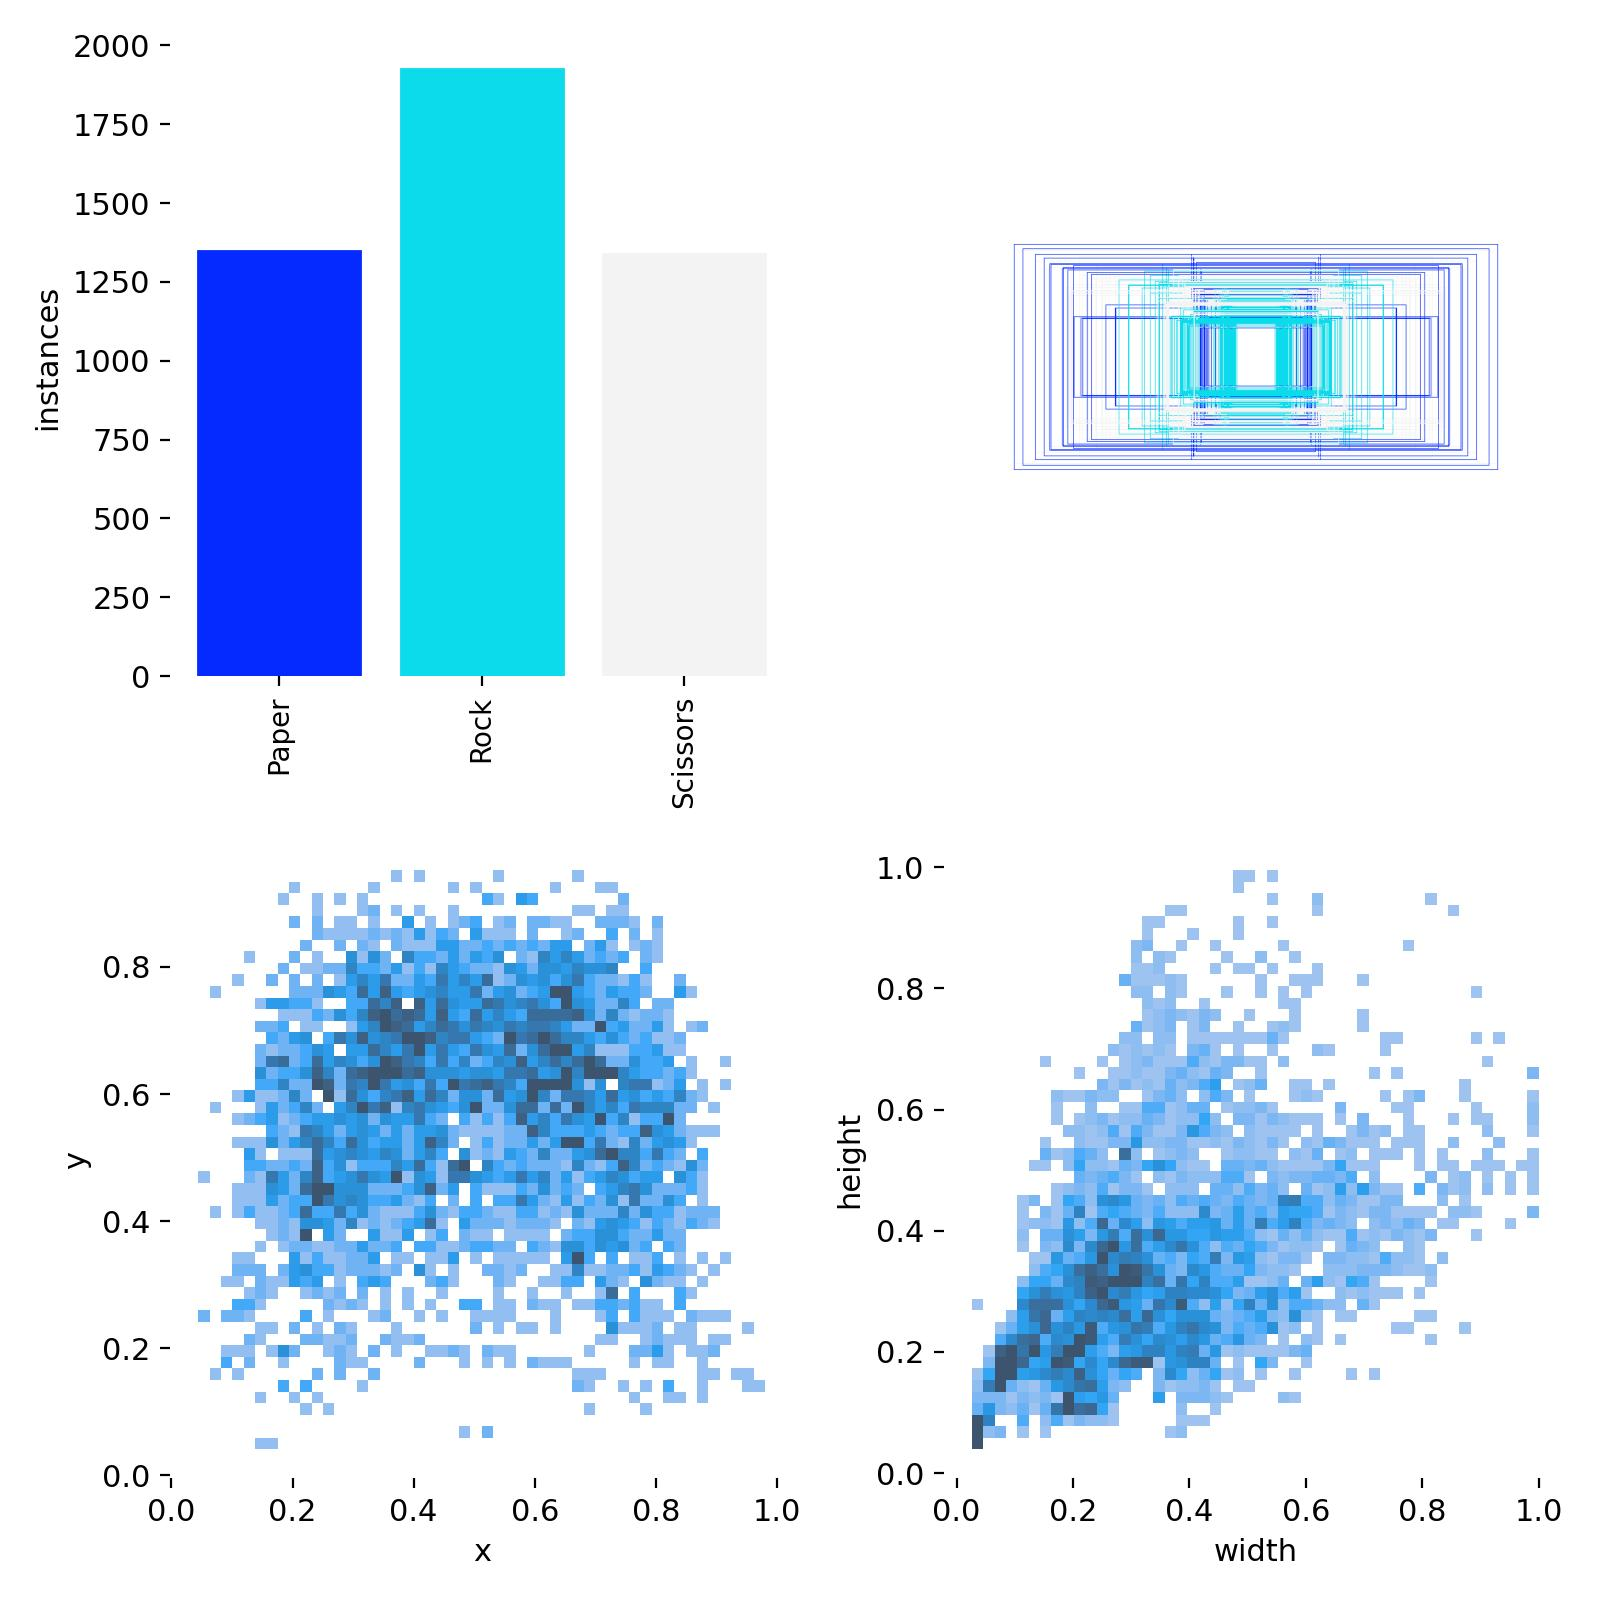

In [12]:
Image(filename='runs/detect/yolo11n_rps/labels.jpg', width=600)

## Inference


In [13]:
# Path to the input video
video_path = 'rps_video.mp4'

# # Perform inference and save results to an output video
video_inf_results = model(video_path, save=True)

print(f"Processed video saved at: {video_inf_results[0].save_dir}")



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/506) /content/rps_video.mp4: 640x384 1 Rock, 57.3ms
video 1/1 (frame 2/506) /content/rps_video.mp4: 640x384 1 Rock, 10.8ms
video 1/1 (frame 3/506) /content/rps_video.mp4: 640x384 1 Rock, 11.8ms
video 1/1 (frame 4/506) /content/rps_video.mp4: 640x384 1 Rock, 11.1ms
video 1/1 (frame 5/506) /content/rps_video.mp4: 640x384 1 Rock, 11.7ms
video 1/1 (frame 6/506) /content/rps_video.mp4: 640x384 1 Rock, 9.7ms
video 1/1 (frame 7/506) /conten

In [14]:
save_to_hub(video_inf_results[0].save_dir+"/rps_video.avi", "rps_video.avi")

rps_video.avi:   0%|          | 0.00/36.0M [00:00<?, ?B/s]

>> Uploaded runs/detect/yolo11n_rps2/rps_video.avi to Gholamreza/yolo11_rock_paper_scissors_detection/rps_video.avi
